# Building a Neural Network for Keyword Spotting using PyTorch and FastAI

**Abstract**

This notebook explores how we can use a neural network to detect different speech commands. We initially explore the dataset and attempt to understand how a system could aim to detect different speech commands and show why it requires a deep neural network. The model is then trained using FastAI APIs on a deep convolutional neural network, so-called M5 architecture. We then utilise a HuggingFace feature extractor and pre-trained model to show how this considerably outperforms our model. Both models are evaluated using a metric accuracy, a confusion matrix, and a plot of training/validation loss.

**Learning Objectives**

 - Understand how to build and train a convolutional neural network with FastAI and PyTorch
 - Understand how to use HuggingFace transformers and models
 - Understand how to create figures and text to evaluate AI models
 - Understand how speech detection and keyword spotting models can be created

**Table of Contents**

1.   Differences with pros and cons in relation to cited sources
2.   Dataset
3.   M5 Model
4.   Training M5 Model with FastAI
5.   Fine Tuning a Model with Hugging Face
6.   References



**Differences with pros and cons in relation to cited sources**

The first half of this tutorial is primarily based on the "Speech Command Classification with torchaudio" tutorial found [here](https://pytorch.org/tutorials/intermediate/speech_command_classification_with_torchaudio_tutorial.html) (source 7). It utilizes the same dataset and model as the referenced tutorial due to the dataset being released with an optimal model.

However, this tutorial goes beyond the original one. First, a more detailed explanation of the dataset is provided. This includes clarifying the elements of an audio data point and how the model aims to utilize them. This is done to offer a more comprehensive understanding of the pipeline and facilitate its adaptation to other speech recognition models. Additionally, the tutorial demonstrates the difficulty of identifying patterns within the dataset, requiring a deep learning model, compared to employing a simpler statistical model.

Furthermore, this tutorial develops the reader's understanding of common Python AI libraries not only using PyTorch but also using FastAI and HuggingFace. This is done to showcase how leveraging different libraries can lead to the creation of better models with greater efficiency. Later the tutorial performs the same task using a prebuilt model, this gives further knowledge in building AI models, but also shows the power of using pre-built models.

By the end of this tutorial, you should have a thorough understanding of two distinct methods for constructing an AI pipeline, as well as an appreciation for how machine learning models can be used to detect speech.

**Dataset**

The first, important step is to import the dataset. The dataset this tutorial will use is the "Speech Commands" dataset, which is a dataset of spoken words designed to help create keyword-spotting artificially intelligent systems (from [source 1](https://arxiv.org/abs/1804.03209)). Hugging Face describes the best use of this dataset as training a model to detect a single word from a set of words, irrespective of background noise and unrelated speech ([source 2](https://huggingface.co/datasets/speech_commands)). There are some examples within the dataset which are just background noise.

We are importing a `torch.utils.data.Dataset` version of the dataset.

In [1]:
import torchaudio
import torch
torch.device("cuda" if torch.cuda.is_available() else "cpu")
issubclass(torchaudio.datasets.SPEECHCOMMANDS, torch.utils.data.Dataset)

True

Using a torch dataset has many advantages, one being it can be passed to a `torch.utils.data.DataLoader` class, which can load multiple samples parallelly. It also gives us common torch methods that are useful to use, especially in integration with PyTorch deep learning APIs.

Let's download these datasets and split them into the training test and validation sets. These are provided out of the box, and mentioned in [source 1](https://arxiv.org/abs/1804.03209). They are split in a specific way to avoid overfitting.

There are 105,829 audio files across all three sets, with 11,005 (10.4%) in the testing set, 9,981 (9.4%) in the validation set and the remaining in the training set.

The training set will be used to train the model, the test set is used after each epoch to show the effectiveness of the dataset. It is not used at all for training. Finally, the validation set is used once the model is trained to show its effectiveness on unseen data. The validation and test set provide similar purposes, the main difference being that the validation set is not seen until the model is completely trained.

In [2]:
import os

class SubsetSC(torchaudio.datasets.SPEECHCOMMANDS):
    # from https://pytorch.org/tutorials/intermediate/speech_command_classification_with_torchaudio_tutorial.html
    def __init__(self, subset: str = None):
        super().__init__("./", download=True)

        def load_list(filename):
            filepath = os.path.join(self._path, filename)
            with open(filepath) as fileobj:
                return [os.path.normpath(os.path.join(os.getcwd(), self._path, line.strip())) for line in fileobj]

        if subset == "validation":
            self._walker = load_list("validation_list.txt")
        elif subset == "testing":
            self._walker = load_list("testing_list.txt")
        elif subset == "training":
            excludes = set(load_list("validation_list.txt") + load_list("testing_list.txt"))
            self._walker = [w for w in self._walker if w not in excludes]


train_set = SubsetSC(subset="training")
test_set = SubsetSC(subset="testing")
validation_set = SubsetSC(subset="validation")

total = len(train_set) + len(test_set) + len(validation_set)
print(
    f"The training set has {len(train_set)}/{total}, the test set has {len(test_set)}/{total}, and the validation set has {len(validation_set)}/{total}"
)

The training set has 105829/126815, the test set has 11005/126815, and the validation set has 9981/126815


Each data point in the dataset is made of 5 points:
1. Waveform
2. Sample Rate
3. Label
4. Speaker ID
5. Utterance Number

In [3]:
waveform, sample_rate, label, speaker_id, utterance_number = train_set[0]

It is useful to understand what these all mean.

A waveform is the shape of a wave, the x-axis is time, and the y-axis is the magnitude of the wave.

We can plot the waveform with `matplotlib`, below is an example of the first point in the training sets waveform. We take the waveform and convert it to a numpy array to plot it.

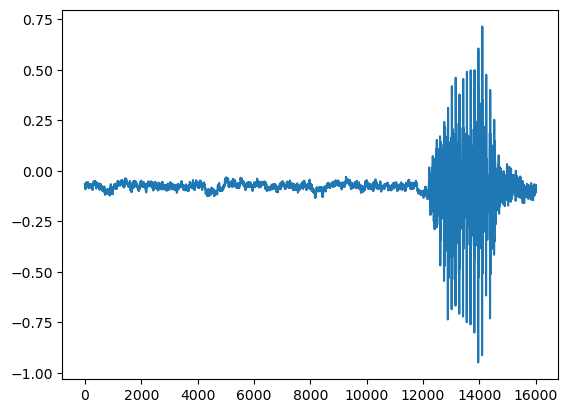

In [4]:
import matplotlib.pyplot as plt

plt.plot(waveform.t().numpy())

The sample rate is effectively how many times per second the file takes samples from the audio source, the higher the sample rate the closer it represents the actual source. The sample rate is often measured in kilo-hertz, i.e. 48kHz means 480,000 samples are taken every second, or 1 sample every 20.83 microseconds (everything in this dataset has a sample rate of 16000Hz). For this dataset the sample rate is not particularly relevant, if we had multiple different sample rates we would need to resample the waveforms so they are consistent. See [here](https://pytorch.org/audio/stable/tutorials/audio_resampling_tutorial.html) for more details.

Waveform and sample rate can be used together to plot a spectrogram, a form of heat map, for example, biologists use a spectrogram to analyse calls of animals ([source 3](https://en.wikipedia.org/wiki/Spectrogram)).

Finally, the speaker ID represents some identification of who said that sample, whilst the utterance number is a unique identifier for that sample.

We can plot spectrograms too, [matplotlib provides this functionality](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.specgram.html), I will plot the first sample from the training set. ([source 2](https://huggingface.co/datasets/speech_commands))

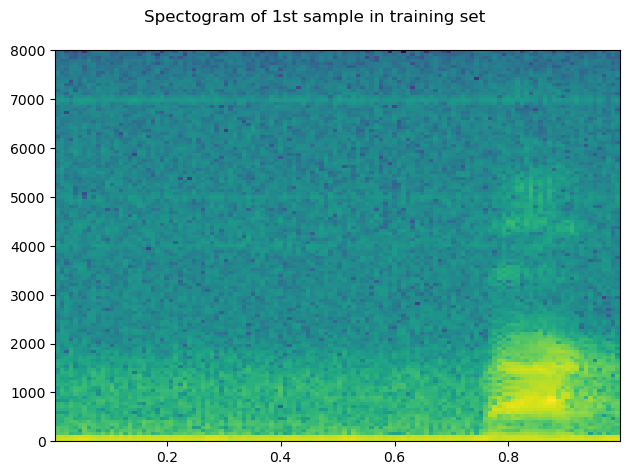

In [5]:
fig, ax = plt.subplots()
ax.specgram(waveform[0], Fs=sample_rate)
fig.suptitle("Spectogram of 1st sample in training set")
fig.tight_layout()

We can also play the sound ([source 4](https://stackoverflow.com/a/71098796/14608493)).

In [7]:
from IPython.display import Audio

Audio(waveform, rate=sample_rate)

We can hear this is someone saying "backwards" and this is confirmed by the label.

In [8]:
print(label)

backward


It is interesting to compare this to another sample, where someone also says "backwards".

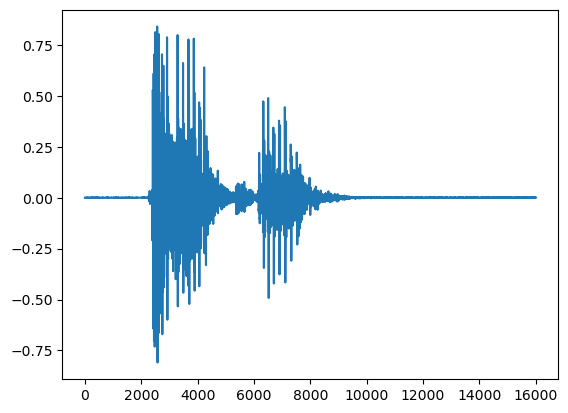

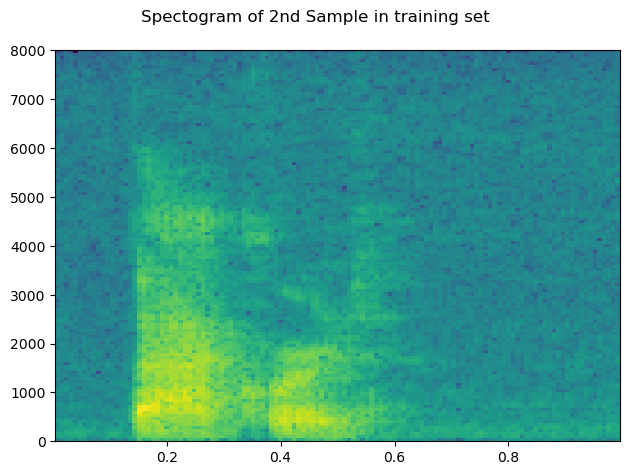

In [9]:
waveform2, sample_rate2, label2, speaker_id2, utterance_number2 = train_set[1]
assert label2 == "backward"
plt.plot(waveform2.t().numpy())
fig, ax = plt.subplots()
ax.specgram(waveform2[0], Fs=sample_rate2)
fig.suptitle("Spectogram of 2nd Sample in training set")
fig.tight_layout()
Audio(waveform2, rate=sample_rate2)

Just by eye, it is hard to spot the similarities between these two plots, although they represent the same sample. As we will see throughout this tutorial the neural network can detect these words based on the waveform and the sample rate with high success.

The labels show the commands said by the speakers in each file, we can get these values. For example, in the training set, we have 35 unique labels. The block below shows all 35 words in our dataset.

In [15]:
labels = list(
    set(
        label
        for waveform, sample_rate, label, speaker_id, utterance_number in train_set
    )
)
print(f"There are {len(labels)} unique labels, from {len(labels)} audio files.\n")
print(labels)

There are 35 unique labels, from 35 audio files.

['cat', 'no', 'right', 'follow', 'happy', 'up', 'bed', 'wow', 'on', 'marvin', 'sheila', 'stop', 'left', 'forward', 'visual', 'zero', 'learn', 'six', 'one', 'yes', 'two', 'tree', 'house', 'eight', 'nine', 'backward', 'four', 'off', 'dog', 'five', 'bird', 'seven', 'three', 'go', 'down']


In [16]:
def pad_waveform(sequences):
    """ pad waveforms with 0s so they are all of the same lengths """
    # Most of the time sequences_size is batch size,
    # but if we have an incomplete batch it may be shorter
    sequences_size = len(sequences)
    max_size = sequences[0].size()
    max_len = max(sequences, key=lambda x: x.size(0)).size(0)

    # create a Tensor of 0s and fill it with the audio sequence from the start
    out = torch.full([sequences_size, max_len, *max_size[1:]], fill_value=0.0)
    for i in range(sequences_size):
        out[i, :sequences[i].size(0), ...] = sequences[i]
    return out.permute(0,2,1)

def collate_fn(batch):
    waveforms = [
        waveform.t()
        for waveform, sample_rate, label, speaker_id, utterance_number in batch
    ]

    # We need to make sure all waveforms are of the same length, otherwise an error is raised
    waveforms = pad_waveform(waveforms)

    targets = [
        torch.tensor(labels.index(label))
        for waveform, sample_rate, label, speaker_id, utterance_number in batch
    ]
    return waveforms, torch.stack(targets)

We now load the data, using a batch size of 64.

In [17]:
batch_size = 64

train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, collate_fn=collate_fn, shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    test_set, batch_size=batch_size, collate_fn=collate_fn, shuffle=True
)
validation_loader = torch.utils.data.DataLoader(
    validation_set, batch_size=batch_size, collate_fn=collate_fn, shuffle=True
)

**M5 Model**

First, we define the M5 model as described by Dai, W. et al. ([source 5](https://arxiv.org/pdf/1610.00087.pdf)). The M5 model is a type of convolutional neural network. Convolutional neural networks are neural networks that have three main types of layers: convolutional layer, pooling layer, and fully connected layer. What each of these layers does will not be described in this tutorial but can be read [here](https://www.ibm.com/topics/convolutional-neural-networks). The model has 4 convolutional layers.

The purpose of this tutorial is not to tune the model perfectly, we assume that is already done by the paper described, hence I will implement it as the paper described.

In [18]:
class M5(torch.nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super().__init__()
        self.conv1 = torch.nn.Conv1d(num_inputs, 32, kernel_size=80, stride=16)
        self.bn1 = torch.nn.BatchNorm1d(32)
        self.pool1 = torch.nn.MaxPool1d(4)
        self.conv2 = torch.nn.Conv1d(32, 32, kernel_size=3)
        self.bn2 = torch.nn.BatchNorm1d(32)
        self.pool2 = torch.nn.MaxPool1d(4)
        self.conv3 = torch.nn.Conv1d(32, 2 * 32, kernel_size=3)
        self.bn3 = torch.nn.BatchNorm1d(2 * 32)
        self.pool3 = torch.nn.MaxPool1d(4)
        self.conv4 = torch.nn.Conv1d(2 * 32, 2 * 32, kernel_size=3)
        self.bn4 = torch.nn.BatchNorm1d(2 * 32)
        self.pool4 = torch.nn.MaxPool1d(4)
        self.fc1 = torch.nn.Linear(2 * 32, num_outputs)

    def forward(self, x):
        x = torch.nn.functional.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)
        x = torch.nn.functional.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)
        x = torch.nn.functional.relu(self.bn3(self.conv3(x)))
        x = self.pool3(x)
        x = torch.nn.functional.relu(self.bn4(self.conv4(x)))
        x = self.pool4(x)
        x = torch.nn.functional.avg_pool1d(x, x.shape[-1]).permute(0, 2, 1)
        x = self.fc1(x)
        return torch.nn.functional.log_softmax(x, dim=2)


model = M5(waveform.shape[0], len(labels))
print(model)

M5(
  (conv1): Conv1d(1, 32, kernel_size=(80,), stride=(16,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=35, bias=True)
)


**Training M5 Model with FastAI**

In this section, I will be training the model using FastAI. It should be clear to see that FastAI encapsulates a lot of the logic away from the user to make it considerably easier to create AI pipelines.

FastAI is an open-source AI library built on top of PyTorch, it provides APIs to make building AI pipelines faster, easier and less error-prone.

First, we load the data into FastAI `DataLoaders`, a class that loads the dataset from the PyTorch dataset in an API compatible with FastAIs API.

We load this into one instance of the `DataLoaders`. In the learning cycle, it uses the first dataset (in our case `train_loader`) to train the data. After each epoch the model "checks" itself against the dataset at index 1 (in our case `test_loader`). We also load the validation set into this instance. It is not used in the training cycle, but afterwards. It makes sense to load it all at once.

In [20]:
from fastai.data.core import DataLoaders

dls = DataLoaders(train_loader, test_loader, validation_loader)

Now, create the learner instance of the model, it uses the dataloaders and the model we just created.

We introduce an optimizer, [source 5](https://arxiv.org/pdf/1610.00087.pdf) recommends using Adam, a form of gradient descent but with an adaptive step size. Adam is short for Adaptive Moment Estimation, it introduces a decaying learning rate by using moving averages. The optimiser's goal is to reduce the loss function towards a global minimum, at a faster rate.

We introduce the loss function as the `CrossEntropyLossFlat`, this uses the PyTorch cross-entropy loss function, but flattens the inputs and targets. It is the same loss function used in the PyTorch example above. It uses the `Adam` optimiser as described in [source 1](https://arxiv.org/abs/1804.03209). The metric for the "effectiveness" of the model is chosen as accuracy, simply, by how many the model predicted correctly divided by how many predictions were made.

Finally, we also introduce a learning rate scheduler. This uses an exponentially decreasing learning rate. The learning rate is defined as base learning rate (0.01) * gamma (0.001) ^ (epoch). Again, this is as described in [source 1](https://arxiv.org/abs/1804.03209), I will not be performing a comparison of different configurations of hyperparameters, but simply sticking to what the paper recommends. The reason for this, is later we will introduce another model, using their "methodology for reproducible and comparable accuracy metrics for this task". To test different hyperparameters, the best way to compare these would be to use the same methods used to compare these models.

In [21]:
import fastai.learner
import fastai.metrics
import fastai.optimizer
import fastai.losses
import fastai.callback.schedule
import fastai.callback.progress

learner = fastai.learner.Learner(
    dls,
    model,
    loss_func=fastai.losses.CrossEntropyLossFlat(),
    opt_func=fastai.optimizer.Adam,
    metrics=[fastai.metrics.accuracy],
)

exp_lr_scheduler = fastai.callback.schedule.SchedExp(start=0.1, end=0.0001)
fit_callbacks = [
    fastai.callback.schedule.ParamScheduler({"lr": exp_lr_scheduler}),
]

Now, run the model. The model logs some metrics such as loss, accuracy and time. We also introduce the `ShowGraphCallback` which plots a graph of the loss at each epoch and each validation epoch. This is useful to see the improvement of the model and to ensure it is not overfitting.

In [22]:
epochs = 4

fit_callbacks.append(fastai.callback.progress.ShowGraphCallback)

epoch,train_loss,valid_loss,accuracy,time
0,1.707171,1.644103,0.506679,07:27
1,1.568477,1.489567,0.545570,07:21
2,1.544453,1.468314,0.556656,07:17
3,1.493397,1.452986,0.562108,07:21


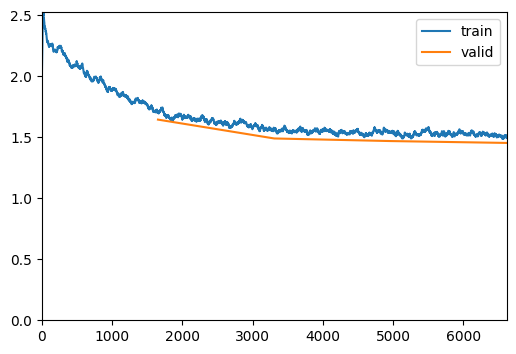

In [31]:
learner.fit(epochs, cbs=fit_callbacks)

We now run the model on the validation set. We can see the loss and the accuracy. Here we output the accuracy.

In [32]:
loss, accuracy = learner.validate(dl=dls[2])
print(f"The model has an accuracy of {accuracy*100:.3f}%, on the validation set, an entirely unseen dataset.")

The model has an accuracy of 57.589%, on the validation set, an entirely unseen dataset.


For example, we can see the confusion matrix

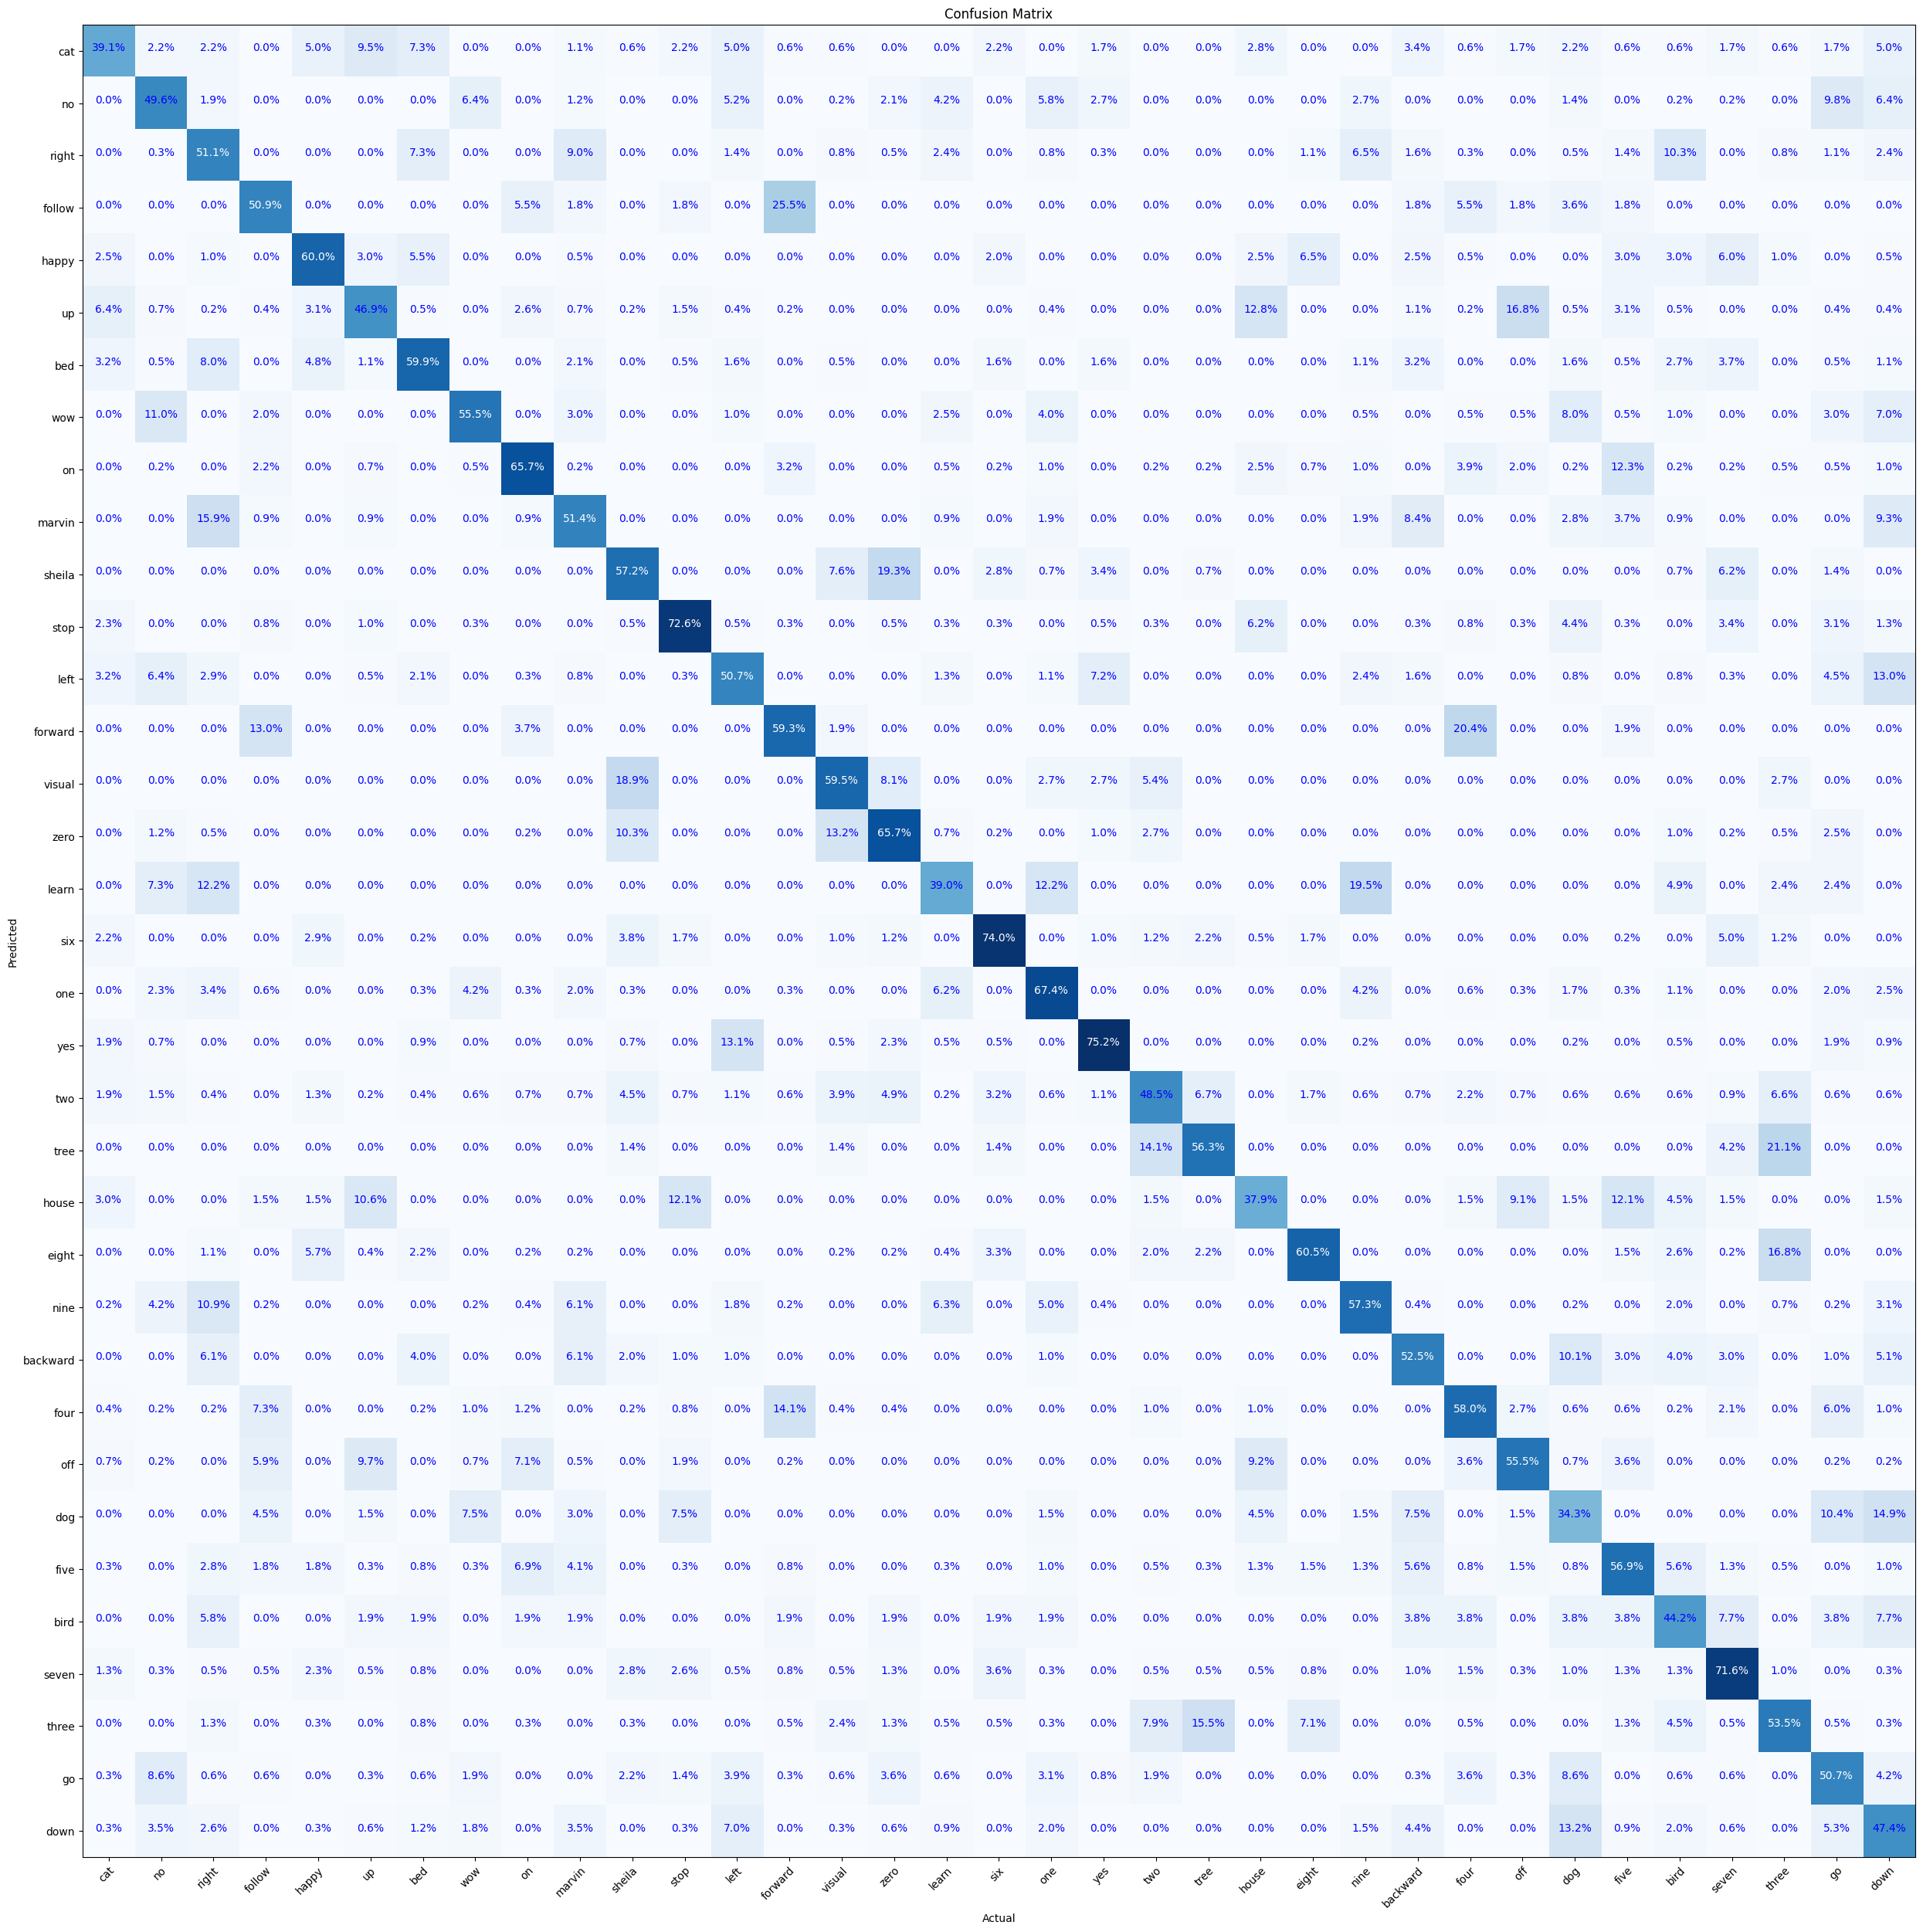

In [33]:
import numpy as np
# This is mostly copied from source 10

# Calculate the confusion matrix
confusion_matrix = np.zeros((len(labels), len(labels)), dtype=np.float64)

_, targets, decoded_preds = learner.get_preds(dl=dls[2], with_decoded=True, with_preds=True, with_targs=True)

decoded_preds = torch.flatten(decoded_preds)
targets = torch.flatten(targets)

# Iterate over each label
for i in range(len(labels)):
    for j in range(len(labels)):
        # Count occurrences where decoded and target values match the labels
        confusion_matrix[i, j] = ((decoded_preds == i) & (targets == j)).sum()

# Normalize the confusion matrix, and times by 100 so we have %
confusion_matrix /= confusion_matrix.sum(axis=1, keepdims=True) * 0.01

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(25, 30))
ax.imshow(confusion_matrix, interpolation="nearest", cmap="Blues")

ax.set_xticks(np.arange(len(labels)), labels)
ax.set_yticks(np.arange(len(labels)), labels)
plt.xlabel("Actual")
plt.ylabel("Predicted")

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Add text annotations
for i in range(len(labels)):
    for j in range(len(labels)):
        if confusion_matrix[i, j] < 50:
            color = "b"
        else:
            color = "w"
        ax.text(j, i, f"{confusion_matrix[i, j]:.1f}%", horizontalalignment="center", color=color)

ax.set_title("Confusion Matrix")
fig.tight_layout()
plt.show()

We can see from the confusion matrix, it is generally very accurate, due to the strong darker diagonal, however some values are not performing particularly well, e.g. "four" and "forward" are often confused.

**Fine Tuning a Model with Hugging Face**

We now introduce a different way to train the same dataset using a pre-trained model, released by MIT [here](https://huggingface.co/MIT/ast-finetuned-speech-commands-v2).

We first load the pre-trained model and feature extractor, as outlined on the Hugging Face website. (directly copied from the link above / [source 9](https://huggingface.co/MIT/ast-finetuned-speech-commands-v2)). I have adapted the config that defines the labels, so it has `{label: id}` consistent with our model.

In [23]:
from transformers import AutoConfig, AutoFeatureExtractor, AutoModelForAudioClassification

extractor = AutoFeatureExtractor.from_pretrained("MIT/ast-finetuned-speech-commands-v2")

# inspired by source 8
config = AutoConfig.from_pretrained(
    "MIT/ast-finetuned-speech-commands-v2",
    num_labels=len(labels),
    id2label=dict(enumerate(labels)),
    label2id={v:k for k,v in dict(enumerate(labels)).items()},
    finetuning_task="audio-classification",
)
pretrained_model = AutoModelForAudioClassification.from_pretrained(
    "MIT/ast-finetuned-speech-commands-v2", config=config
)

We freeze the layers of this pretrained model,

In [24]:
# source 6
for parameter in pretrained_model.parameters():
    parameter.requires_grad = False

but add two fully connected layers after to fine tune the model.

In [25]:
class PretrainedModel(torch.nn.Module):
    def __init__(self, num_outputs):
        super().__init__()
        self.model = pretrained_model.base_model
        self.fc1 = torch.nn.Linear(self.model.config.hidden_size, 128)
        self.fc2 = torch.nn.Linear(128, num_outputs)

    def forward(self, x):
        features = extractor(
            torch.squeeze(x, dim=1).cpu().numpy(), sampling_rate=16000, return_tensors="pt"
        ).to("cuda")
        # Pass the extracted features through the transformer model
        pretrained_output = self.model(**features)

        # Apply 2 fully connected layers for classification
        x = torch.nn.functional.relu(self.fc1(pretrained_output.last_hidden_state[:, 0]))
        x = self.fc2(x)
        return torch.nn.functional.log_softmax(x, dim=1)

model2 = PretrainedModel(num_outputs=len(labels))
print(model2)

PretrainedModel(
  (model): ASTModel(
    (embeddings): ASTEmbeddings(
      (patch_embeddings): ASTPatchEmbeddings(
        (projection): Conv2d(1, 768, kernel_size=(16, 16), stride=(10, 10))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ASTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ASTLayer(
          (attention): ASTAttention(
            (attention): ASTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ASTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ASTIntermediate(
            (dense): Linear(in_features=768, out_

Use the same configurations as before

epoch,train_loss,valid_loss,accuracy,time
0,1.363398,1.375324,0.77024,25:35
1,1.270362,1.228471,0.82731,25:51
2,1.135937,1.154319,0.87614,25:07
3,1.067561,1.051354,0.89532,24:38


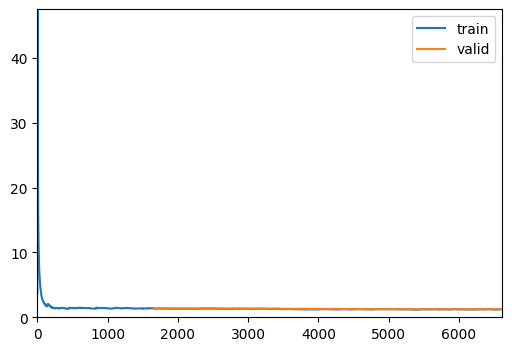

In [ ]:
learner = fastai.learner.Learner(
    dls,
    model2,
    loss_func=fastai.losses.CrossEntropyLossFlat(),
    opt_func=fastai.optimizer.Adam,
    metrics=[fastai.metrics.accuracy],
)

exp_lr_scheduler = fastai.callback.schedule.SchedExp(start=0.1, end=0.0001)

learner.fit(epochs, cbs=fit_callbacks)

Now, we analyse the performance on the validation set (using the same methods) with our second model to see if there are any improvements.

In [ ]:
loss, accuracy = learner.validate(dl=dls[2])
print(f"The model has an accuracy of {accuracy*100:.3f}%, on the validation set, an entirely unseen dataset.")

The model has an accuracy of 89.545%, on the validation set, an entirely unseen dataset.


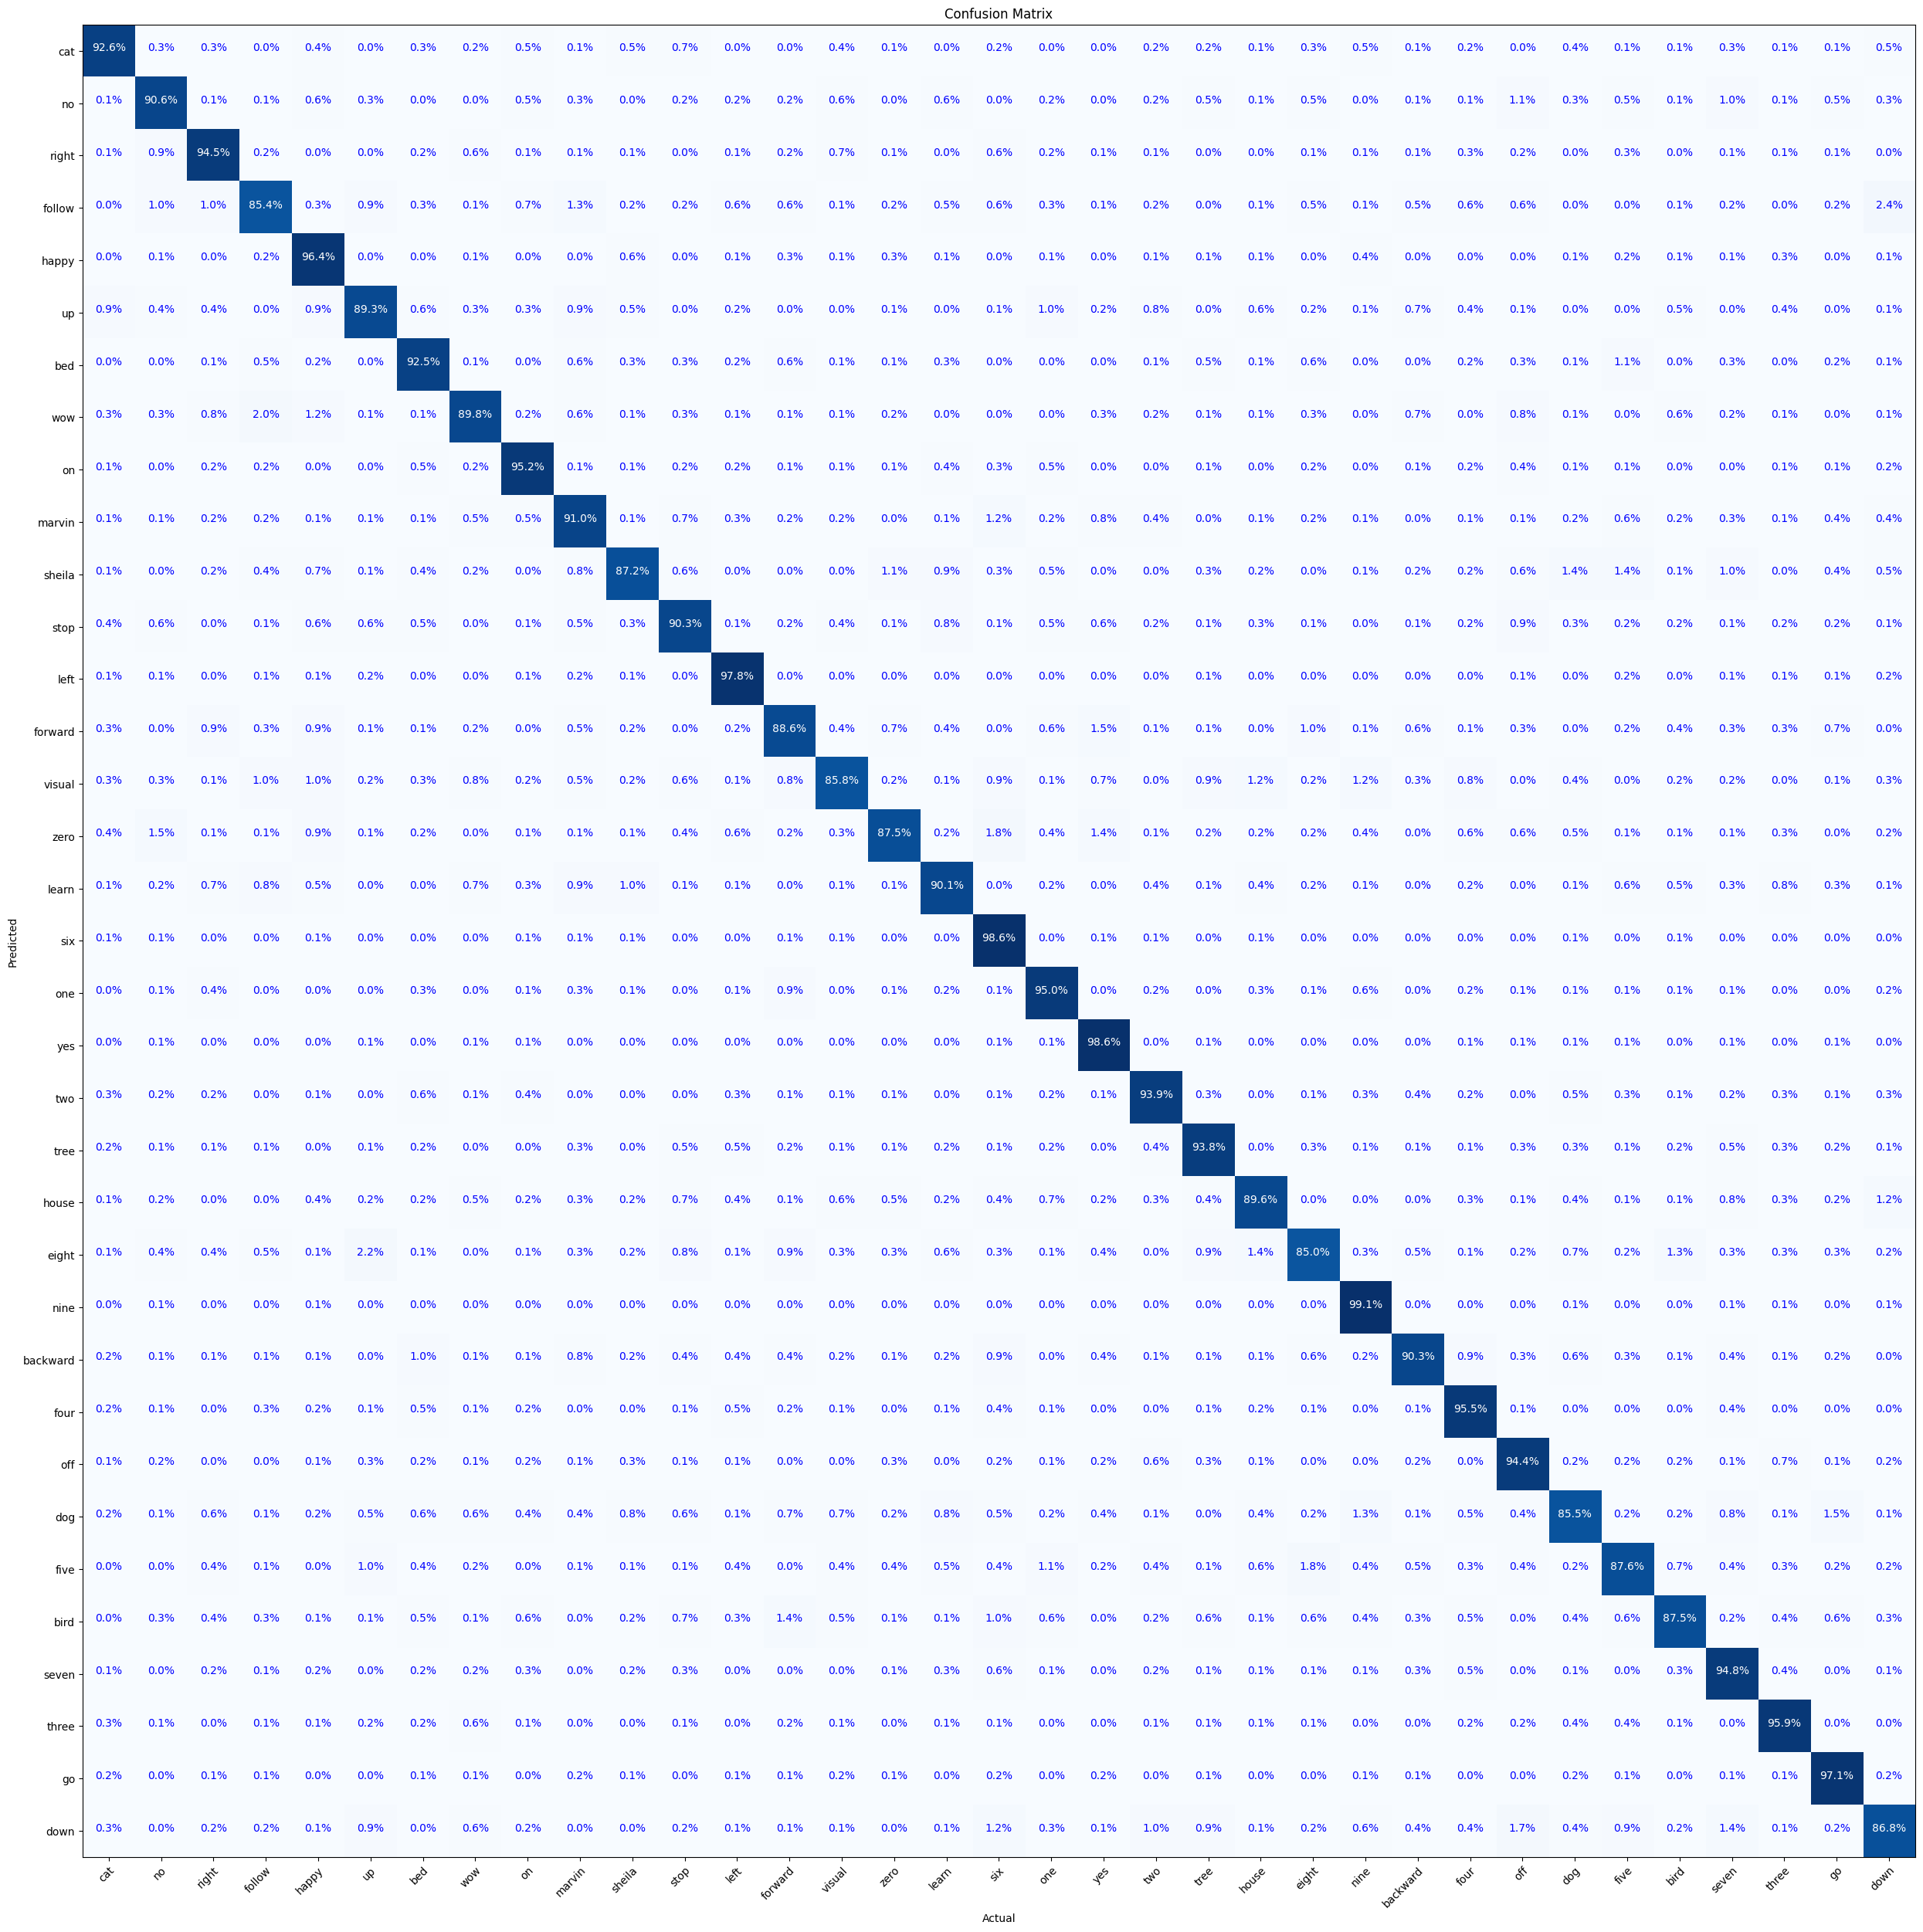

In [27]:
# same as above
confusion_matrix = np.zeros((len(labels), len(labels)), dtype=np.float64)

_, targets, decoded_preds = learner.get_preds(dl=dls[2], with_decoded=True, with_preds=True, with_targs=True)

decoded_preds = torch.flatten(decoded_preds)
targets = torch.flatten(targets)

# Iterate over each label
for i in range(len(labels)):
    for j in range(len(labels)):
        # Count occurrences where decoded and target values match the labels
        confusion_matrix[i, j] = ((decoded_preds == i) & (targets == j)).sum()

# Normalize the confusion matrix, and times by 100 so we have %
confusion_matrix /= confusion_matrix.sum(axis=1, keepdims=True) * 0.01

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(25, 30))
ax.imshow(confusion_matrix, interpolation="nearest", cmap="Blues")

ax.set_xticks(np.arange(len(labels)), labels)
ax.set_yticks(np.arange(len(labels)), labels)
plt.xlabel("Actual")
plt.ylabel("Predicted")

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Add text annotations
for i in range(len(labels)):
    for j in range(len(labels)):
        if confusion_matrix[i, j] < 50:
            color = "b"
        else:
            color = "w"
        ax.text(j, i, f"{confusion_matrix[i, j]:.1f}%", horizontalalignment="center", color=color)

ax.set_title("Confusion Matrix")
fig.tight_layout()
plt.show()

As you can see using the pretrained model with a feature extractor yields significantly better results, with the same number of epochs. This can be seen by the considerably higher accuracy on the validation set, the higher percentages within the confusion matrix and the lower loss within training. The lower loss within training should be treated with caution as it could be a sign of overfitting, however in this case it is not. The model still performs less well on some words, but it has 85%+ accuracy in every class.

**References**


[1] https://arxiv.org/abs/1804.03209

[2] https://huggingface.co/datasets/speech_commands

[3] https://en.wikipedia.org/wiki/Spectrogram

[4] https://stackoverflow.com/a/71098796/14608493

[5] https://arxiv.org/pdf/1610.00087.pdf

[6] https://stackoverflow.com/a/62526423/14608493

[7] https://pytorch.org/tutorials/intermediate/speech_command_classification_with_torchaudio_tutorial.html

[8] https://github.com/huggingface/transformers/blob/272f48e734300cf6df66b5fcdaf462e47de3ccd6/examples/pytorch/audio-classification/run_audio_classification.py#L366

[9] https://huggingface.co/MIT/ast-finetuned-speech-commands-v2

[10] https://matplotlib.org/stable/gallery/images_contours_and_fields/image_annotated_heatmap.html#sphx-glr-gallery-images-contours-and-fields-image-annotated-heatmap-py